In [1]:
import sys

sys.argv = ['']
sys.path.append("../..")
from src.grid_world import GridWorld
from examples.agent import Agent
import torch.nn as nn
from torch.optim import Optimizer
from torch import optim
import random
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F

In [2]:
class QNet(nn.Module):
    """
    Q(s, a) 网络
    输入: 状态one-hot向量（num_states维）
    输出: 所有动作的Q值（num_actions维）
    """

    def __init__(self, num_states, num_actions):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(num_states, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def size(self):
        return len(self.buffer)

In [4]:
class DQN(Agent):
    def __init__(self, env, num_episodes=5000, episode_length=1000,
                 gamma=0.9, alpha=1e-2, epsilon=0.1,
                 update_freq=100, mini_batch_size=64):
        super().__init__(
            env=env,
            epsilon=epsilon,
            gamma=gamma,
            num_episodes=num_episodes,
            episode_length=episode_length
        )

        self.alpha = alpha
        # 初始化Q网络与目标网络
        self.QNet = QNet(self.num_states, self.num_actions)
        self.target_QNet = QNet(self.num_states, self.num_actions)
        self.target_QNet.load_state_dict(self.QNet.state_dict())

        # 对应策略
        self.policy = np.ones((self.num_states, self.num_actions)) / self.num_actions
        self.target_policy = np.ones((self.num_states, self.num_actions)) / self.num_actions

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.QNet.parameters(), lr=alpha)

        self.update_freq = update_freq
        self.buffer = ReplayBuffer(capacity=episode_length*num_episodes)
        self.mini_batch_size = mini_batch_size
        self.step_counter = 0  # 用于定期更新目标网络

    def run(self):
        episodes_per_iteration = int(self.num_episodes / 10)
        for iteration in range(10):
            progress_desc = f"Iteration {iteration + 1}/10"
            with tqdm(total=episodes_per_iteration, desc=progress_desc, unit='episode') as pbar:
                for episode_idx in range(episodes_per_iteration):
                    global_episode = iteration * episodes_per_iteration + episode_idx + 1

                    self.env.reset()
                    current_state = self.env.start_state
                    current_state_idx = self.state2idx(current_state)
                    current_action_idx = self.choose_action(current_state_idx)

                    episode_reward = 0
                    step_count = 0

                    while step_count < self.episode_length:
                        current_action = self.idx2action(current_action_idx)
                        next_state, reward, done, _ = self.env.step(current_action)
                        next_state_idx = self.state2idx(next_state)
                        next_action_idx = self.choose_action(next_state_idx)

                        episode_reward += reward

                        # 存入经验
                        self.buffer.add(current_state_idx, current_action_idx, reward, next_state_idx, done)

                        # 更新Q网络与策略
                        if self.buffer.size() >= self.mini_batch_size:
                            self.update()
                            self.update_Q()

                        # 更新当前状态和动作
                        current_state_idx = next_state_idx
                        current_action_idx = next_action_idx
                        step_count += 1
                        self.step_counter += 1

                        # 每 update_freq 步同步一次目标网络和 target_policy
                        if self.step_counter % self.update_freq == 0:
                            self.update_target_policy()

                        if done:
                            break

                    if global_episode % 10 == 0:
                        pbar.set_postfix({
                            'episode': f"{global_episode}",
                            'return': f"{episode_reward:.3f}"
                        })
                    pbar.update(1)

    def update(self):
        """
        从ReplayBuffer采样批量经验，更新QNet及policy
        """
        states, actions, rewards, next_states, dones = self.buffer.sample(self.mini_batch_size)

        states_tensor = F.one_hot(torch.tensor(states, dtype=torch.long), num_classes=self.num_states).float()
        next_states_tensor = F.one_hot(torch.tensor(next_states, dtype=torch.long), num_classes=self.num_states).float()
        actions_tensor = torch.tensor(actions, dtype=torch.long)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float)
        dones_tensor = torch.tensor(dones, dtype=torch.float)

        # 当前Q值
        q_values = self.QNet(states_tensor)
        q_values = q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)

        # 目标Q值
        with torch.no_grad():
            next_q_values = self.target_QNet(next_states_tensor)
            max_next_q_values, _ = next_q_values.max(dim=1)
            td_targets = rewards_tensor + self.gamma * max_next_q_values * (1 - dones_tensor)

        # 损失与优化
        loss = self.loss_fn(q_values, td_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 更新对应的 policy
        for idx in range(self.mini_batch_size):
            self.update_policy(states[idx])

        return loss.item()

    def update_policy(self, st_idx):
        """
        更新 QNet 对应的 policy
        """
        st_tensor = F.one_hot(torch.tensor(st_idx, dtype=torch.long), num_classes=self.num_states).float().unsqueeze(0)
        with torch.no_grad():
            q_values = self.QNet(st_tensor).squeeze(0).numpy()
        greedy_action = np.argmax(q_values)
        for a in range(self.num_actions):
            if a == greedy_action:
                self.policy[st_idx, a] = 1 - self.epsilon + self.epsilon / self.num_actions
            else:
                self.policy[st_idx, a] = self.epsilon / self.num_actions

    def update_target_policy(self):
        """
        更新目标网络和 target_policy
        """
        self.target_QNet.load_state_dict(self.QNet.state_dict())
        for st_idx in range(self.num_states):
            st_tensor = F.one_hot(torch.tensor(st_idx, dtype=torch.long), num_classes=self.num_states).float().unsqueeze(0)
            with torch.no_grad():
                q_values = self.target_QNet(st_tensor).squeeze(0).numpy()
            greedy_action = np.argmax(q_values)
            for a in range(self.num_actions):
                if a == greedy_action:
                    self.target_policy[st_idx, a] = 1 - self.epsilon + self.epsilon / self.num_actions
                else:
                    self.target_policy[st_idx, a] = self.epsilon / self.num_actions

    def update_Q(self):
        for st_idx in range(self.num_states):
            st_tensor = F.one_hot(torch.tensor(st_idx, dtype=torch.long), num_classes=self.num_states).float().unsqueeze(0)
            with torch.no_grad():
                q_values = self.QNet(st_tensor).squeeze(0).numpy()
            self.Q[st_idx, :] = q_values
        return self.Q


In [5]:
env = GridWorld()
env.reward_step = -1
env.reward_target = 10

Iteration 10/10: 100%|██████████| 100/100 [00:22<00:00,  4.41episode/s, episode=1000, return=-10.000]


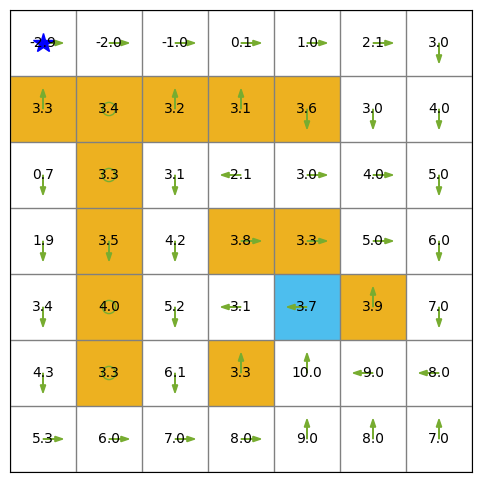

In [6]:
agent = DQN(env, epsilon=0.3, gamma=1, num_episodes=1000, episode_length=1000, alpha=1e-3)
agent.run()
agent.render_static()